<a href="https://colab.research.google.com/github/JuniorHZ19/CNN-PARA-DETECION-DE-OBJETOS/blob/main/R-CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:

!pip uninstall opencv-contrib-python opencv-python
!pip install opencv-contrib-python

Found existing installation: opencv-contrib-python 4.10.0.84
Uninstalling opencv-contrib-python-4.10.0.84:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/cv2/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python-4.10.0.84.dist-info/*
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Core-e6d3f451.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Gui-5dea4132.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Test-d435aae7.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5Widgets-e392eaf8.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libQt5XcbQpa-3bf8a55a.so.5.15.13
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libX11-xcb-0e257303.so.1.0.0
    /usr/local/lib/python3.10/dist-packages/opencv_contrib_python.libs/libXau-00ec42fe.so.6.0.0
    /usr/local/lib/python3.10

In [3]:
import os
import xml.etree.ElementTree as ET
from PIL import Image
import torch
from torch.utils.data import Dataset

class PascalVOCDataset(Dataset):

    def __init__(self, images_dir, annotations_dir, transform=None):

        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transform = transform

        # Lista de todas las imágenes y sus anotaciones
        self.image_filenames = [
            f for f in os.listdir(images_dir) if f.endswith((".jpg", ".png"))
        ]

    def __len__(self):
        """Devuelve el tamaño del dataset."""
        return len(self.image_filenames)

    def __getitem__(self, idx):
        """
        Devuelve una imagen y su correspondiente anotación.

        Parámetros:
        - idx: Índice de la imagen.

        Retorna:
        - image: Tensor de la imagen.
        - target: Diccionario con bounding boxes y etiquetas.
        """
        # Cargar la imagen
        image_filename = self.image_filenames[idx]

        image_path = os.path.join(self.images_dir, image_filename)
        image = Image.open(image_path).convert("RGB")

        # Cargar la anotación correspondiente
        annotation_path = os.path.join(
            self.annotations_dir, os.path.splitext(image_filename)[0] + ".xml"
        )

        target = self._parse_annotation(annotation_path)


        return np.array(image), target

    def _parse_annotation(self, annotation_path):
        """
        Analiza un archivo XML Pascal VOC y extrae los bounding boxes y etiquetas.

        Parámetros:
        - annotation_path: Ruta del archivo XML.

        Retorna:
        - target: Diccionario con claves:
            'boxes': Lista de bounding boxes en formato [xmin, ymin, xmax, ymax].
            'labels': Lista de etiquetas (clases).
        """
        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall("object"):
            label = obj.find("name").text

            bndbox = obj.find("bndbox")
            xmin = int(bndbox.find("xmin").text)
            ymin = int(bndbox.find("ymin").text)
            xmax = int(bndbox.find("xmax").text)
            ymax = int(bndbox.find("ymax").text)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label)

        # Convertir labels a índices (si es necesario, define un mapeo de clase a índice)
        label_to_index = {label: idx + 1 for idx, label in enumerate(set(labels))}
        labels = [label_to_index[label] for label in labels]

        target = {
            "boxes":boxes,
            "labels": labels
        }
        return target

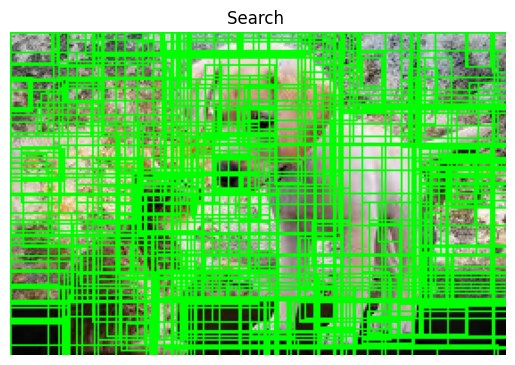

In [39]:
#Creando funcion para generacion de regioness propuestas:

import cv2
import matplotlib.pyplot as plt

# Cargar la imagen
image = cv2.imread('/content/dataset/imagenes/0002.jpg')

def get_Region_Proposals(img,max_regiones=2000):
# Crear un objeto de Selective Search
 ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

 image_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# Configurar la imagen para Selective Search
 ss.setBaseImage(image_bgr)

# Modo rápido o calidad

 ss.switchToSelectiveSearchFast()  # Más rápido pero menos preciso

 #ss.switchToSelectiveSearchQuality()  # Más preciso pero más lento

# Ejecutar Selective Search para obtener las regiones propuestas
 rects = ss.process()



 return rects[:max_regiones]


rectas_propuestas=get_Region_Proposals(image)

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Dibujar las regiones propuestas en la imagen
for (x, y, w, h) in rectas_propuestas:  # Limitar a las primeras 100 regiones para visualizar
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (0, 255, 0), 1)
# Mostrar la imagen con Matplotlib
plt.imshow(image_rgb)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

(224, 224, 3)


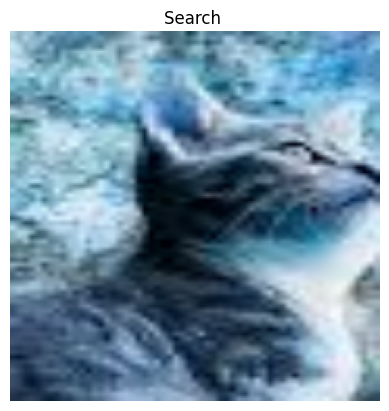

In [40]:
#Funcion redimension dee regiones para entrada al cnn:

def extract_region(image,rect,size=(224,224)):
  x=rect[0]
  y=rect[1]
  w=rect[2]
  h=rect[3]

  if x < 0 or y < 0 or x + w > image.shape[1] or y + h > image.shape[0]:
        raise ValueError("La región extraída excede los límites de la imagen.")
        print(rect)
  region=image[y:y+h, x:x+w] #crop imagen segun recta

  if region.size == 0:  # Verificar si la región extraída es válida
        raise ValueError("La región extraída tiene dimensiones inválidas.")

  img_region=cv2.resize(region, size) #redimensionar para entrada a vgg16 imanges 224x224

  return img_region

img=extract_region(image,rectas_propuestas[100])

print(img.shape)

plt.imshow(img)
plt.axis('off')  # Ocultar los ejes
plt.title("Search ")
plt.show()

In [19]:
#funcion calcular iou para comparar la region propuesta con la real:

def calculateIoU(real_bb,predict_bb):

   xl=max(real_bb[0],predict_bb[0]) #maximo entre x de cada extremo top_left de cada bounidnig box
   yl=max(real_bb[1],predict_bb[1]) #maximo entre y de cada extremo top_left de cada bounidnig box

   xr=min(real_bb[2],predict_bb[2]) #min entre x de cada extremo bottom_right de cada bounidnig box
   yr=min(real_bb[3],predict_bb[3]) #min entre y de cada extremo bottom_right de cada bounidnig box

   intersecion_area=(xr-xl)*(yr-yl)  #calculamos el area de la interseccion

   area_realbb=(real_bb[2]-real_bb[0])*(real_bb[3]-real_bb[1]) # calculamos el area del bounding box real con cada una de sus coedenadas
   area_predictbb=(predict_bb[2]-predict_bb[0])*(predict_bb[3]-predict_bb[1]) #calculamos el area del boudnign box predicho con cada una de sus coedenadas

   union_area= (area_realbb + area_predictbb)- intersecion_area #Calculamos el area de la union

   IoU= intersecion_area/union_area #calculamos IoU dividiendo la interesccion con la union

   return IoU





In [20]:
#Selecionar regiones propuestas que iran al  modelo SVM  usando criterio de IoU donde  <0.3 sera considerados como fondo ,0.3< IoU <0.5 sera omitido para evitar ambuiguidad
#Mayores a 0.5> sera clasificado como la clase del bbox que mas se apropixma al IoU.

def select_labels_regiones(regiones, ground_truth_boxes, ground_truth_labels, iou_threshold=0.7):

  labels=[]
  regiones_selected=[]
  real_bbox_selected=[]
  for region in regiones:
    max_iou = 0
    best_label = 0  # Inicializar como fondo por defecto
    best_box = None

    for box, gt_label in zip(ground_truth_boxes, ground_truth_labels):

        iou = calculateIoU(region, box)
        if iou > max_iou:  #se quedara con el mayor iou conseguido de los objetos que coincida asi no tener probelmas de etiquetar fondo si se pasa a los siguientes boxes
            max_iou = iou
            if iou <=0.3:
              best_label = 0
              best_box = None

            elif  0.3<iou<iou_threshold:
               best_label = 'no seleccionada'
               best_box = None

            elif  iou >= iou_threshold:  # Verifica si el IoU supera el umbral
                best_label = gt_label
                best_box = box

    if best_label != 'no seleccionada':
     regiones_selected.append(region)
     real_bbox_selected.append(best_box)
     labels.append(best_label)


  return regiones_selected,real_bbox_selected,labels

#selecionamos el bbox real de cada bbox que se propuesto y contenga un objeto (iou>0.7) y no consideremos el fondo, esto para entrenar el modelo regresor

def select_bbox_regiones(regiones_selected,real_regiones_selected,labels):

    real_bboxs=[]
    regiones=[]
    labels_selected=[]
    for region,real_bbox,label in zip(regiones_selected,real_regiones_selected,labels):

        if label!='fondo':
            real_bboxs.append(real_bbox)
            regiones.append(region)
            labels_selected.append(label)



    return regiones,real_bboxs,labels_selected





In [8]:
#funciones para calcular las ranfomaciones (que tanto se desplza el boudnig box propuesto del real t_x, t_y, t_w, t_h) cual entrara al regresor que calcuialra estos translacion

def calculate_translations(bbox_pred, bbox_real, epsilon = 1e-10):
    """
    Calcula los desplazamientos (t_x, t_y, t_w, t_h) para ajustar las cajas de referencia a las cajas de verdad.

    :param xmin_pred, ymin_pred, xmax_pred, ymax_pred: coordenadas extremas de la caja de la verdad (ground truth)
    :param xmin_ref, ymin_ref, xmax_ref, ymax_ref: coordenadas extremas de la caja de referencia (anchor box)
    :return: desplazamientos t_x, t_y, t_w, t_h
    """
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = bbox_pred
    xmin_real, ymin_real, xmax_real, ymax_real=bbox_real

    # Paso 1: Calcular el centro y el tamaño de la caja de referencia
    real_w = xmax_real - xmin_real
    real_h = ymax_real - ymin_real
    real_cx = (xmin_real + xmax_real) / 2
    real_cy = (ymin_real + ymax_real) / 2

    # Paso 2: Calcular el centro y el tamaño de la caja de la verdad
    gt_w = xmax_pred - xmin_pred
    gt_h = ymax_pred - ymin_pred
    gt_cx = (xmin_pred + xmax_pred) / 2
    gt_cy = (ymin_pred + ymax_pred) / 2

    # Validación para evitar valores inválidos en anchuras y alturas
    real_w = max(real_w, epsilon)
    real_h = max(real_h, epsilon)
    gt_w = max(gt_w, epsilon)
    gt_h = max(gt_h, epsilon)

    # Paso 3: Calcular los desplazamientos (t_x, t_y, t_w, t_h)
    t_x = (gt_cx - real_cx) / (real_w+epsilon)
    t_y = (gt_cy - real_cy) / (real_h+epsilon)
    t_w = np.log(gt_w / (real_w +epsilon))
    t_h = np.log(gt_h / (real_h+epsilon) )


    return [t_x, t_y, t_w, t_h]

import numpy as np

def apply_translations_to_proposed_bbox(bbox_pred, translations, epsilon=1e-10): #hcer lo inverso y pasar las transformaciones aplciadas a bbox predicho para calcular bboxreal
    """
    Aplica las translaciones a un bounding box propuesto para calcular el bounding box real (ground truth).

    :param bbox_pred: Bounding box propuesto (xmin_pred, ymin_pred, xmax_pred, ymax_pred).
    :param translations: Lista de translaciones [t_x, t_y, t_w, t_h].
    :param epsilon: Valor pequeño para evitar divisiones por cero en los cálculos.
    :return: Bounding box real (xmin_real, ymin_real, xmax_real, ymax_real).
    """
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = bbox_pred
    t_x, t_y, t_w, t_h = translations

    # Paso 1: Calcular el centro y el tamaño de la caja propuesta (predicha)
    pred_w = xmax_pred - xmin_pred
    pred_h = ymax_pred - ymin_pred
    pred_cx = (xmin_pred + xmax_pred) / 2
    pred_cy = (ymin_pred + ymax_pred) / 2

    # Paso 2: Aplicar las translaciones
    real_cx = pred_cx - t_x * (pred_w + epsilon)
    real_cy = pred_cy - t_y * (pred_h + epsilon)
    real_w = pred_w * np.exp(-t_w)  # Usamos el exponente negativo para invertir la relación
    real_h = pred_h * np.exp(-t_h)  # Usamos el exponente negativo para invertir la relación

    # Paso 3: Calcular las nuevas coordenadas del bounding box real
    xmin_real = real_cx - real_w / 2
    ymin_real = real_cy - real_h / 2
    xmax_real = real_cx + real_w / 2
    ymax_real = real_cy + real_h / 2

    return [xmin_real, ymin_real, xmax_real, ymax_real]

In [43]:
#Crear extractor de  features con VGG16:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
import cv2
import numpy as np




def extract_features_from_regions(image,regiones,modelo):

    all_features = []
    # Definir las transformaciones para preprocesar las imágenes
    transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizar según ImageNet
    ])

    for region in regiones:

        region_extracted=extract_region(image,region)

        # Convertir la región redimensionada a tensor
        input_tensor = transform(region_extracted).to(device)
        input_tensor = input_tensor.unsqueeze(0)  # Añadir batch dimension
        input_tensor = Variable(input_tensor)

        # Extraer características usando VGG16
        with torch.no_grad():
            features = modelo.features(input_tensor)  # Extraer las características
            flattened = features.view(features.size(0), -1)
        all_features.append(flattened.squeeze().cpu().numpy())  # Almacenar las características

    return np.array(all_features)



In [44]:
from torchvision import transforms
import numpy as np
from torch.utils.data import Dataset, random_split
# Directorios del dataset
images_dir = "/content/dataset/imagenes"
annotations_dir = "/content/dataset/anotaciones"

# Definir transformaciones (opcional)
transform = transforms.Compose([
    transforms.ToTensor() # Convierte la imagen a tensor

])

# Crear el dataset
dataset = PascalVOCDataset(images_dir, annotations_dir, transform=transform)

# Particionar dataset en train y test
train_size = int(0.8 * len(dataset))  # 80% para entrenamiento
test_size = len(dataset) - train_size  # El resto para prueba

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
img,target=train_dataset[2]
print(target)
print(img.shape)

{'boxes': [[28, 23, 153, 185]], 'labels': [1]}
(194, 259, 3)


In [45]:
#ENTRENAR CLASFICADOR SVM
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression


# SVM modelo
svm = SVC(kernel='rbf', C=1.0)

vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()
# Número de épocas
epochs = 5

for epoch in range(epochs):
    accuraty_total = 0

    for image, target in train_dataset:
        # Obtener regiones propuestas
        regiones_propuestas = get_Region_Proposals(image, max_regiones=2000)
        # Seleccionar regiones
        regiones_selected, real_bbox_selected, labels = select_labels_regiones(regiones_propuestas, target['boxes'], target['labels'])
        # Extraer características
        features = extract_features_from_regions(image,regiones_selected,vgg16)

        # Entrenar el SVM
        svm.fit(features, labels)

    # Evaluar en el conjunto de prueba
    for image_test, target_test in test_dataset:
        regiones_propuestas = get_Region_Proposals(image_test, max_regiones=2000)
        regiones_selected_test, real_bbox_selected_test, labels_test = select_labels_regiones(regiones_propuestas, target_test['boxes'], target_test['labels'])
        features_test = extract_features_from_regions(image_test,regiones_selected_test,vgg16)

        y_pred = svm.predict(features_test)

        accuraty_total += accuracy_score(y_pred, labels_test)
        print(accuraty_total)
    accuraty_total /= len(test_dataset)
    print(f"Precisión del SVM: {accuraty_total:.2f}")
    print(features.shape)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


KeyboardInterrupt: 

In [ ]:
#ENTRENTAR REGRESOR
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import numpy as np

# Ruta del directorio que contiene los archivos XML
xml_dir = "/content/dataset/anotaciones"
img_dir='/content/dataset/imagenes'
# Leer todos los archivos XML


regressor = LinearRegression()

for xml_file in sorted(os.listdir(xml_dir)):
    if xml_file.endswith(".xml"):
        xml_path = os.path.join(xml_dir, xml_file)
        info = parse_voc_xml(xml_path)

        image = cv2.imread(f"{img_dir}/{info['filename']}")
        ground_truth_boxes=[]
        ground_truth_labels=[]

        for obj in info["objects"]:
           ground_truth_boxes.append(obj['bbox'])
           ground_truth_labels.append(obj['label'])


        regiones_propuestas=get_Region_Proposals(image,max_regiones=2000)

        regiones_selected,real_bbox_selected,labels=select_labels_regiones(regiones_propuestas, ground_truth_boxes, ground_truth_labels)

        regiones,real_bboxs,labels_selected=select_bbox_regiones(regiones_selected,real_bbox_selected,labels)

        features = extract_features_from_regions(regiones)
        translations=[]

        for region,truth_box in zip(regiones,real_bboxs):
          translations.append(calculate_translations(region,truth_box))

        print(np.array(translations).shape)
        regressor.fit(features, np.array(translations))






Número de regiones propuestas: 2621
(802, 4)
Número de regiones propuestas: 537
(126, 4)
Número de regiones propuestas: 2252
(390, 4)
Número de regiones propuestas: 563
(248, 4)
Número de regiones propuestas: 409
(137, 4)
Número de regiones propuestas: 1130
(480, 4)
Número de regiones propuestas: 488
(174, 4)
Número de regiones propuestas: 562
(149, 4)
Número de regiones propuestas: 4192
(1706, 4)
Número de regiones propuestas: 432
(52, 4)


Número de regiones propuestas: 2583
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato
gato


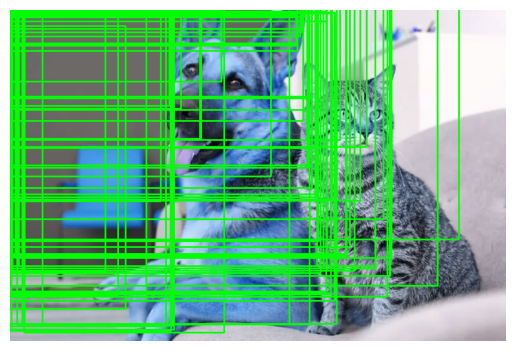

In [ ]:
#prediccion con imagen:


url = "/content/dataset/imagenes/0001.jpg"# @param {type:"string"}

image = cv2.imread(url)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

regiones_propuestas=get_Region_Proposals(image_rgb,max_regiones=2000)

features = extract_features_from_regions(regiones_propuestas)

clases=svm.predict(features)

translations=regressor.predict(features)

for clase,translation,region_propuesta in zip(clases,translations,regiones_propuestas):
  if clase != 'fondo':
     print(clase)
     pred_bbox=region_propuesta+translation

     cv2.rectangle(image, (int(pred_bbox[0]), int(pred_bbox[1])), (int(pred_bbox[2]), int(pred_bbox[3])), (0, 255, 0), 2)



plt.imshow(image)
plt.axis('off')  # Desactivar los ejes para mostrar solo la imagen
plt.show()
